In [13]:
import argparse
import torch
import torch.nn as nn
import utils
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt

In [14]:
def fwd_gradients(obj, x):
    dummy = torch.ones_like(obj)
    derivative = torch.autograd.grad(obj, x, dummy, create_graph= True)[0]
    return derivative

def hamilton_jacobi_equation(u, tx):
    u_tx = fwd_gradients(u, tx)
    u_t = u_tx[:, 0:1]
    u_x = u_tx[:, 1:2]
    # u_xx=0
    # # u_xx = fwd_gradients(u_x, tx)[:, 1:2]
    # nu = 0#10000
    e = u_t + 1/2*(u_x)**2
    return e

def resplot(x, t, t_data, x_data, Exact, u_pred):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(x, Exact[:,0],'-')
    plt.plot(x, u_pred[:,0],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("Initial condition ($t=0$)")
    
    plt.subplot(2, 2, 2)
    t_step = int(0.25*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.25$")
    
    plt.subplot(2, 2, 3)
    t_step = int(0.5*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.5$")
    
    plt.subplot(2, 2, 4)
    t_step = int(0.99*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.99$")
    plt.show()
    plt.close()

In [15]:
class LinearBlock(nn.Module):

    def __init__(self, in_nodes, out_nodes):
        super(LinearBlock, self).__init__()
        self.layer = nn.utils.weight_norm(nn.Linear(in_nodes, out_nodes), dim = 0)

    def forward(self, x):
        x = self.layer(x)
        x = torch.tanh(x) 
        return x

class PINN(nn.Module):

    def __init__(self, layer_list):
        super(PINN, self).__init__()
        device = torch.device("cuda:2")# if torch.cuda.is_available() else "cpu")
        self.input_layer = nn.utils.weight_norm(nn.Linear(layer_list[0], layer_list[1]), dim = 0)
        self.hidden_layers = self._make_layer(layer_list[1:-1])
        self.output_layer = nn.Linear(layer_list[-2], layer_list[-1])
        
    def _make_layer(self, layer_list):
        layers = []
        for i in range(len(layer_list) - 1):
            block = LinearBlock(layer_list[i], layer_list[i + 1])
            layers.append(block)
        return nn.Sequential(*layers)

    def forward(self, x):
        t_0, x_0 = x[:,0:1], x[:,1:2]
        x = self.input_layer(x)
        x = torch.tanh(x) 
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        #print(x.shape)
        #x = torch.absolute(x_0)+torch.tanh(t_0)*x
        x = (1-torch.tanh(t_0)) * torch.absolute(x_0) + torch.tanh(t_0)*x 
        #x = (1-torch.tanh(t_0)) * (x_0)**2 + torch.tanh(t_0)*x 
        #x = torch.tanh(t_0)*x
        #return -x+torch.absolute(x_0)
        return x

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)

def pinn(layer_list):
    model = PINN(layer_list)
    model.apply(weights_init)
    return model

In [16]:
num_t = 256
num_x = 256
# num_t = 128
# num_x = 128
num_epochs = 20000
num_hidden = 4
num_nodes = 128
lr = 1e-2

In [17]:
device = torch.device("cuda:2")
print("Operation mode: ", device)

Operation mode:  cuda:2


In [18]:
def lone_generator(num_t, num_x, typ='train'):
    N_f = num_t*num_x
    t = np.linspace(0, 1, num_t).reshape(-1,1) # T x 1
    x = np.linspace(-1, 1, num_x).reshape(-1,1) # N x 1
    T = t.shape[0]
    N = x.shape[0]
    T_star = np.tile(t, (1, N)).T  # N x T
    X_star = np.tile(x, (1, T))  # N x T
    
    # Initial condition and boundary condition
    u = np.zeros((N, T))  # N x T
    # u[:,0:1] = np.absolute(x)
    u[:,0:1] = np.power(x, 2)
    
    t_data = T_star.flatten()[:, None]
    x_data = X_star.flatten()[:, None]
    u_data = u.flatten()[:, None]
    
    t_data_f = t_data.copy()
    x_data_f = x_data.copy()
    
    if typ == 'train':
        idx = np.random.choice(np.where((x_data == -1) | (x_data == 1))[0], num_t)
        t_data = t_data[idx]
        x_data = x_data[idx]
        u_data = u_data[idx]
        
        init_idx = np.random.choice(N-1, num_x-2, replace=False) + 1
        t_data = np.concatenate([t_data, np.zeros((num_x-2,1))], axis=0)
        x_data = np.concatenate([x_data, x[init_idx]], axis=0)
        u_data = np.concatenate([u_data, u[init_idx,0:1]], axis=0)
        
        return t_data, x_data, u_data, t_data_f, x_data_f
   
    else:
        return t_data_f, x_data_f

In [19]:
eq = 'HJPDE'

In [20]:
t_data, x_data, u_data, t_data_f, x_data_f = lone_generator(num_t, num_x)  

In [21]:
variables = torch.FloatTensor(np.concatenate((t_data, x_data), 1)).to(device)
variables_f = torch.FloatTensor(np.concatenate((t_data_f, x_data_f), 1)).to(device)
variables_f.requires_grad = True
u_data = torch.FloatTensor(u_data).to(device)

In [22]:
layer_list = [2] + num_hidden * [num_nodes] + [1]
pinn = pinn(layer_list).to(device)

/store/DAMTP/sh2146/mamba/envs/HJ/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [23]:
optimizer = torch.optim.Adam(pinn.parameters(), betas=(0.999,0.999), lr=lr)
loss_graph = []
ls = 100
bep = 0

In [24]:
for ep in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        
        # Full batch
        u_hat = pinn(variables)
        u_hat_f = pinn(variables_f)
        
    
        loss_f = torch.mean(hamilton_jacobi_equation(u_hat_f, variables_f) ** 2)
            
        # loss_u = torch.mean((u_hat - u_data) ** 2)
        #loss_u = torch.mean((u_hat-torch.tensor(x_data).to(device))**2)
        loss = loss_f # + 
        loss.backward() 
        optimizer.step()
        
        l = loss.item()
        loss_graph.append(l)
        
        if l < ls or True:
            ls = l
            bep = ep
            torch.save(pinn.state_dict(), './'+eq+'_nn1d.pth')
            
        if ep % 1000 == 0:
            print(f"Train loss: {l}") 

  0%|          | 6/20000 [00:00<06:34, 50.72it/s]

Train loss: 0.062151066958904266


  5%|▌         | 1008/20000 [00:18<05:52, 53.92it/s]

Train loss: 0.021306177601218224


 10%|█         | 2009/20000 [00:37<05:32, 54.12it/s]

Train loss: 0.014824563637375832


 15%|█▌        | 3011/20000 [00:56<05:09, 54.86it/s]

Train loss: 0.004996796604245901


 20%|██        | 4007/20000 [01:14<04:56, 53.87it/s]

Train loss: 0.000614783784840256


 25%|██▌       | 5009/20000 [01:33<04:38, 53.75it/s]

Train loss: 0.0010524800745770335


 30%|███       | 6011/20000 [01:51<04:18, 54.10it/s]

Train loss: 0.0005811997689306736


 35%|███▌      | 7007/20000 [02:10<04:00, 54.00it/s]

Train loss: 0.00020697503350675106


 40%|████      | 8008/20000 [02:29<03:44, 53.49it/s]

Train loss: 0.00011892893235199153


 45%|████▌     | 9010/20000 [02:47<03:21, 54.57it/s]

Train loss: 3.0946994229452685e-05


 50%|█████     | 10006/20000 [03:05<03:04, 54.11it/s]

Train loss: 2.8773814847227186e-05


 55%|█████▌    | 11008/20000 [03:24<02:45, 54.29it/s]

Train loss: 1.33631365315523e-05


 60%|██████    | 12006/20000 [03:47<03:33, 37.44it/s]

Train loss: 5.3105295592104085e-06


 65%|██████▌   | 13006/20000 [04:14<03:06, 37.43it/s]

Train loss: 3.6412525332707446e-06


 70%|███████   | 14006/20000 [04:41<02:40, 37.42it/s]

Train loss: 1.9823819457087666e-06


 75%|███████▌  | 15006/20000 [05:08<02:12, 37.68it/s]

Train loss: 1.1031783060388989e-06


 80%|████████  | 16005/20000 [05:35<01:45, 37.98it/s]

Train loss: 8.417115395786823e-07


 85%|████████▌ | 17005/20000 [06:01<01:20, 37.22it/s]

Train loss: 5.257383008938632e-07


 90%|█████████ | 18006/20000 [06:28<00:53, 37.32it/s]

Train loss: 3.3952693456740235e-07


 95%|█████████▌| 19006/20000 [06:54<00:26, 37.49it/s]

Train loss: 1.869110093366544e-07


100%|██████████| 20000/20000 [07:20<00:00, 45.42it/s]


[Best][Epoch: 19999] Train loss: 1.3048196478848695e-07


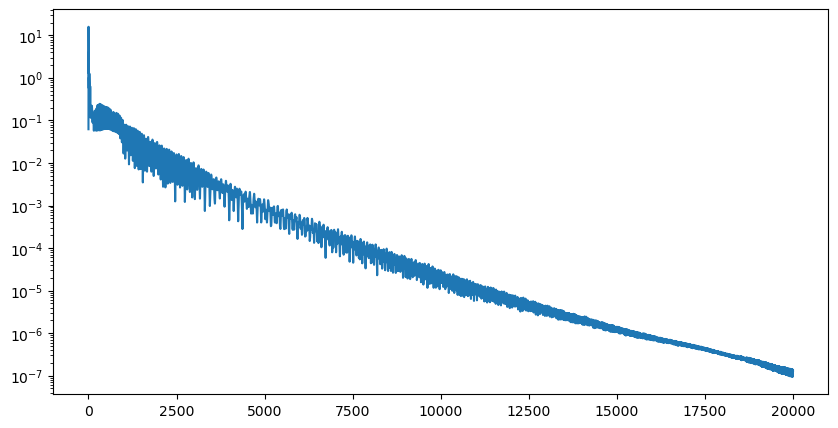

In [25]:
print(f"[Best][Epoch: {bep}] Train loss: {ls}") 
plt.figure(figsize=(10, 5))
plt.plot(loss_graph)
plt.yscale('log')
plt.show()

In [26]:
pinn.load_state_dict(torch.load('./'+eq+'_nn1d.pth'))

<All keys matched successfully>

In [27]:
t_test, x_test = lone_generator(256, 256, typ='test')
t = np.linspace(0, 1, 256).reshape(-1,1)
#print(np.linspace(0, 1, 101))
#print(t)
x = np.linspace(-1, 1, 256).reshape(-1,1)
#print('hi')
#print(x)
T = t.shape[0]
N = x.shape[0]
test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
print(test_variables.shape)

torch.Size([65536, 2])


torch.Size([65536, 1])


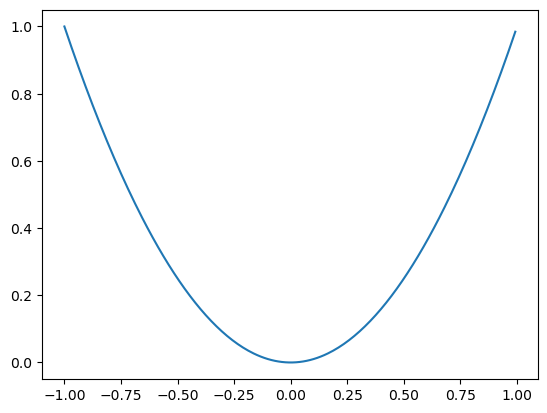

[[1.         0.9980404  0.99608064 ... 0.5038918  0.5019649  0.50004166]
 [0.99215686 0.9901969  0.98823684 ... 0.49612105 0.49420154 0.49228603]
 [0.9843137  0.98235345 0.98039305 ... 0.4883657  0.48645452 0.48454735]
 ...
 [0.9843137  0.98235536 0.9803968  ... 0.48859316 0.4866876  0.4847862 ]
 [0.99215686 0.99019855 0.9882401  ... 0.49633634 0.49442345 0.4925142 ]
 [1.         0.9980418  0.99608344 ... 0.50409317 0.50217336 0.50025684]]
L2 Relative Error: 0.5672731399536133


In [28]:
t_test, x_test = lone_generator(256, 256, typ='test')
t = np.linspace(0, 1, 256).reshape(-1,1)
#print(np.linspace(0, 1, 101))
#print(t)
x = np.linspace(-1, 1, 256).reshape(-1,1)
#print(x)
T = t.shape[0]
N = x.shape[0]
test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
with torch.no_grad():
    u_pred = pinn(test_variables)
print(u_pred.shape)
u_pred = u_pred.cpu().numpy().reshape(N,T)

#print(u_pred.shape)
t_step = int(0.99*len(t))
#print(u_pred[:,t_step])
#plt.plot(x, u_pred[:,t_step],'--')
#plt.show()

# reference data
# def f(x):
#     if torch.absolute(x)<=1:
#         return 1/2*(x**2+t**2)
#     else:
#         return torch.absolute(x)+t-1/2


def f_l1(x,y):
    f = torch.zeros(256, 256)
    for j in range(len(y)):
        for i in range(len(x)):
            if torch.absolute(x[i])<y[j]:
                f[i,j] = 1/(2*y[j])*x[i]**2
            else:
                f[i,j] = torch.absolute(x[i])-y[j]/2
    return f

# function if initial function is x^2:
def f(x,y):
    f = torch.zeros(256, 256)
    for j in range(len(y)):
        for i in range(len(x)):
                f[i,j] = x[i]**2/(2*y[j]+1)
    return f
        
# def f(x):
#     f = []
#     for i in range(len(x[:,0])):
#         for j in range(len(x[:,1])):
#             if torch.absolute(x[i,0])<=x[j,1]:
#                 f.append(1/2*x[i,0]**2)
#             else:
#                 f.append(torch.absolute(x[i, 0])-x[j, 1]/2)
#     return f


interval_x = torch.arange(-1,1, 2/256)
# #print(interval_x)
interval_t = torch.arange(0,1, 1/256)
# #print(interval_t)

# interval = torch.stack((interval_x, interval_t), 1)
# print(interval)

#interval = torch.cartesian_prod(interval_x, interval_t)
#print(interval[0, 1])

#data = torch.tensor(list(map(f, interval_x, interval_t)))

data = f(interval_x, interval_t)

# data =  f(interval) 
# Exact = np.real(data['usol'])
  
Exact = data.cpu().numpy()

plt.plot(interval_x, Exact[:,0])
plt.show()

# print(u_pred)
# print(u_pred[:,:-1])
#err = u_pred[:,:-1]-Exact

print(u_pred)

err = err = u_pred-Exact

# f_0 = []
# for i in range(len(interval[:,0])):
#     for j in range(len(interval[:,1])):
#         if interval[j,1] == 0.5:
#             if torch.absolute(interval[i,0])<=interval[j,1]:
#                 f_0.append(1/2*interval[i,0]**2)
#             else:
#                 f_0.append(torch.absolute(interval[i, 0])-interval[j, 1]/2)
            
# print(f_0)

#print(err)

err = np.linalg.norm(err,2)/np.linalg.norm(data,2)   
print(f"L2 Relative Error: {err}")

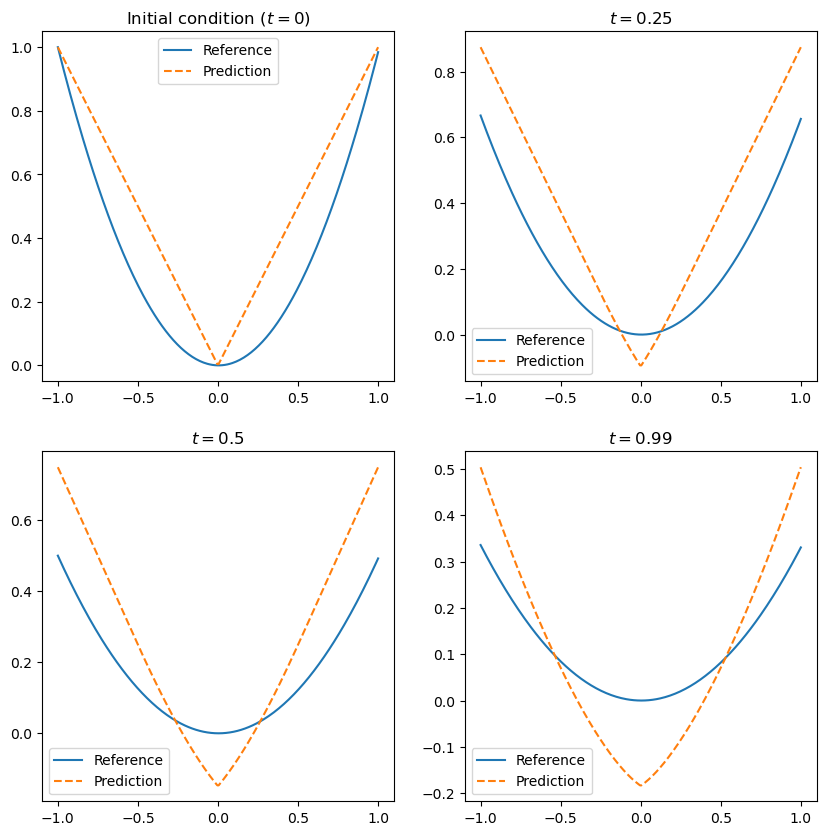

In [29]:
resplot(x, t, t_data, x_data, data, u_pred)

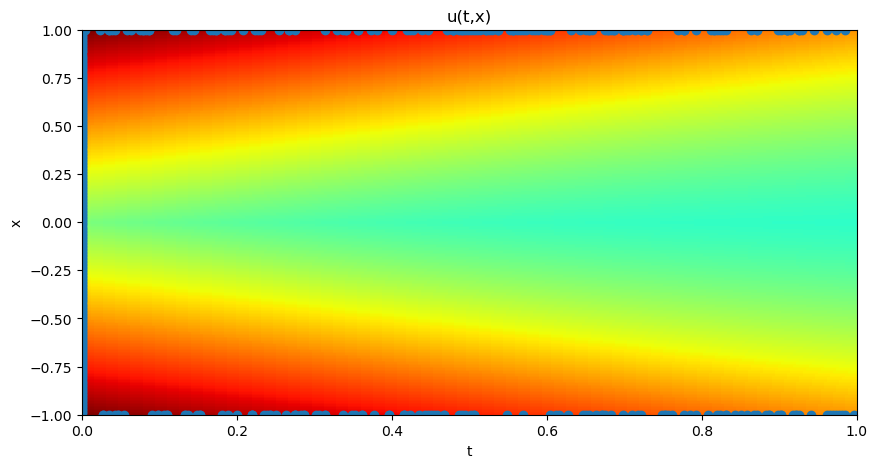

In [30]:
plt.figure(figsize=(10, 5))
plt.imshow(u_pred, interpolation='nearest', cmap='jet',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
plt.clim(-1, 1)
plt.ylim(-1,1)
plt.xlim(0,1)
plt.scatter(t_data, x_data)
plt.xlabel('t')
plt.ylabel('x')
plt.title('u(t,x)')
plt.show()